# Лабораторная работа №1
Выполнила: Большова Елизавета Александровна

**В ходе лабораторной работы** был создан и протестирован пайплайн загрузки и предобработки данных для задачи классификации изображений. Проведенный эксперимент по оценке производительности `DataLoader` с различными параметрами `batch_size` и `num_workers` позволил сделать следующие выводы:

1.  **Влияние параллельной загрузки (`num_workers`):**
    *   Использование нескольких рабочих потоков (`num_workers=2`) является ключевым фактором ускорения. В среднем, это сокращает общее время загрузки в 1.5-1.6 раза по сравнению с однопоточным режимом (`num_workers=0`). Однако превышение рекомендованного системой количества потоков (`num_workers=4 в Colab`) приводит к дополнительным накладным расходам и замедлению процесса.

2.  **Влияние размера батча (`batch_size`):**
    *    Увеличение размера батча стабильно снижает общее время прохода по датасету. Наилучшая пропускная способность и самое быстрое время загрузки (5.47 секунды) были достигнуты при максимальном протестированном размере батча `batch_size=128`.

**Общий итог:**
Для достижения максимальной эффективности пайплайна загрузки данных необходимо подбирать оптимальное сочетание параметров. Для данной среды (Google Colab) и датасета наиболее производительной оказалась конфигурация с **максимально возможным размером батча (`batch_size=128`) и количеством рабочих потоков, соответствующим числу доступных ядер CPU (`num_workers=2`)**.

In [ ]:
# Импорт библиотек
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [46]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
# Определение всех функций

def prepare_dataset(path_dataset, output_dir='./processed_data', csv_path='./plant_dataset.csv'):

    # Преобразуем изображения и сохраняем информацию в CSV
    os.makedirs(output_dir, exist_ok=True)
    data_info = []
    label_map = {
        'Potato_healthy': 2,
        'Potato_sick_early': 1,
        'Potato_sick_late': 0
    }

    idx = 0
    for path_dir in sorted(os.listdir(path_dataset)):
        full_dir = os.path.join(path_dataset, path_dir)
        if not os.path.isdir(full_dir):
            continue
        label = label_map.get(path_dir)
        if label is None:
            continue

        print(f"Обработка папки: {path_dir}")
        for filename in tqdm(sorted(os.listdir(full_dir))):
            full_path = os.path.join(full_dir, filename)
            try:
                image = Image.open(full_path).convert("RGB").resize((180, 180))
                save_path = os.path.join(output_dir, f'{idx}.png')
                image.save(save_path)
                data_info.append([save_path, label])
                idx += 1
            except Exception as e:
                print(f"Не удалось обработать файл {full_path}: {e}")

    df = pd.DataFrame(data_info, columns=['image_path', 'label'])
    df.to_csv(csv_path, index=False)
    print(f"\nИнформация о датасете ({len(df)} изображений) сохранена в {csv_path}")

In [48]:
class CustomDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.loc[idx, 'image_path']
        label = self.data.loc[idx, 'label']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def dummy_loss_function(outputs, targets):
    # Заглушка для функции
    loss_fn = torch.nn.CrossEntropyLoss()
    return loss_fn(outputs, targets)

def iterate_dataloader(dataloader, num_classes):
    for images, labels in tqdm(dataloader, desc="Итерация по батчам", leave=False):
        # Имитация работы модели
        current_batch_size = images.shape[0]
        dummy_logits = torch.randn(current_batch_size, num_classes)
        loss = dummy_loss_function(dummy_logits, labels)
    # Возвращаем последний батч для возможной визуализации
    return images, labels

def evaluate_pipeline_performance(dataset, num_classes):
    # Сетка параметров для тестирования
    batch_sizes = [16, 64, 128]
    num_workers_list = [0, 2, 4]
    results = []

    # Последний батч для визуализации
    last_batch_for_viz = None

    for batch_size in batch_sizes:
        for num_workers in num_workers_list:
            print(f"\nТестируем: batch_size={batch_size}, num_workers={num_workers}")

            loader = DataLoader(
                dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True
            )

            start_time = time.time()
            # Запускаем полный проход по данным
            images, labels = iterate_dataloader(loader, num_classes)
            elapsed_time = time.time() - start_time

            results.append({
                'Batch Size': batch_size,
                'Num Workers': num_workers,
                'Время (секунды)': elapsed_time
            })
            print(f"-> Общее время: {elapsed_time:.2f} секунд")

            # Сохраняем батч от последней итерации для визуализации
            last_batch_for_viz = (images, labels)

    return results, last_batch_for_viz

In [58]:
# Для визуализации батча
def visualize_batch(images, labels, class_names):

    num_to_show = min(24, len(images))

    # Де-нормализация для корректного отображения цветов
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Создаем фигуру с сеткой 3x8
    fig, axes = plt.subplots(3, 8, figsize=(22, 9))
    fig.suptitle("Визуализация изображений из последнего батча", fontsize=20)

    # Превращаем сетку осей в плоский список для удобной итерации
    axes = axes.flatten()

    for i in range(num_to_show):
        ax = axes[i]

        # Переводим тензор в numpy и де-нормализуем
        img_np = images[i].permute(1, 2, 0).numpy()
        img_denorm = std * img_np + mean
        img_denorm = np.clip(img_denorm, 0, 1)

        ax.imshow(img_denorm)

        # Добавляем текст на изображение
        label_text = class_names[labels[i].item()]
        ax.text(5, 15, label_text,
                 color='white',
                 backgroundcolor='black',
                 fontsize=10,
                 fontweight='bold',
                 # Добавим небольшой бокс вокруг текста
                 bbox=dict(facecolor='black', alpha=0.5, pad=1))

        ax.set_xticks([])
        ax.set_yticks([])

    for i in range(num_to_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Файл ./plant_dataset.csv уже существует, подготовка данных пропущена.
Датасет создан, количество изображений: 2100

Тестируем: batch_size=16, num_workers=0


Итерация по батчам:   0%|          | 0/132 [00:00<?, ?it/s]

-> Общее время: 8.65 секунд

Тестируем: batch_size=16, num_workers=2


Итерация по батчам:   0%|          | 0/132 [00:00<?, ?it/s]

-> Общее время: 5.83 секунд

Тестируем: batch_size=16, num_workers=4


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Итерация по батчам:   0%|          | 0/132 [00:00<?, ?it/s]

-> Общее время: 8.04 секунд

Тестируем: batch_size=64, num_workers=0


Итерация по батчам:   0%|          | 0/33 [00:00<?, ?it/s]

-> Общее время: 6.93 секунд

Тестируем: batch_size=64, num_workers=2


Итерация по батчам:   0%|          | 0/33 [00:00<?, ?it/s]

-> Общее время: 8.07 секунд

Тестируем: batch_size=64, num_workers=4


Итерация по батчам:   0%|          | 0/33 [00:00<?, ?it/s]

-> Общее время: 5.72 секунд

Тестируем: batch_size=128, num_workers=0


Итерация по батчам:   0%|          | 0/17 [00:00<?, ?it/s]

-> Общее время: 8.88 секунд

Тестируем: batch_size=128, num_workers=2


Итерация по батчам:   0%|          | 0/17 [00:00<?, ?it/s]

-> Общее время: 5.47 секунд

Тестируем: batch_size=128, num_workers=4


Итерация по батчам:   0%|          | 0/17 [00:00<?, ?it/s]

-> Общее время: 6.71 секунд

Итоговая таблица производительности
+--------------+---------------+-------------------+
|   Batch Size |   Num Workers |   Время (секунды) |
+==============+===============+===================+
|           16 |             0 |           8.65063 |
+--------------+---------------+-------------------+
|           16 |             2 |           5.82578 |
+--------------+---------------+-------------------+
|           16 |             4 |           8.04259 |
+--------------+---------------+-------------------+
|           64 |             0 |           6.92543 |
+--------------+---------------+-------------------+
|           64 |             2 |           8.06665 |
+--------------+---------------+-------------------+
|           64 |             4 |           5.72072 |
+--------------+---------------+-------------------+
|          128 |             0 |           8.87735 |
+--------------+---------------+-------------------+
|          128 |             2 |  

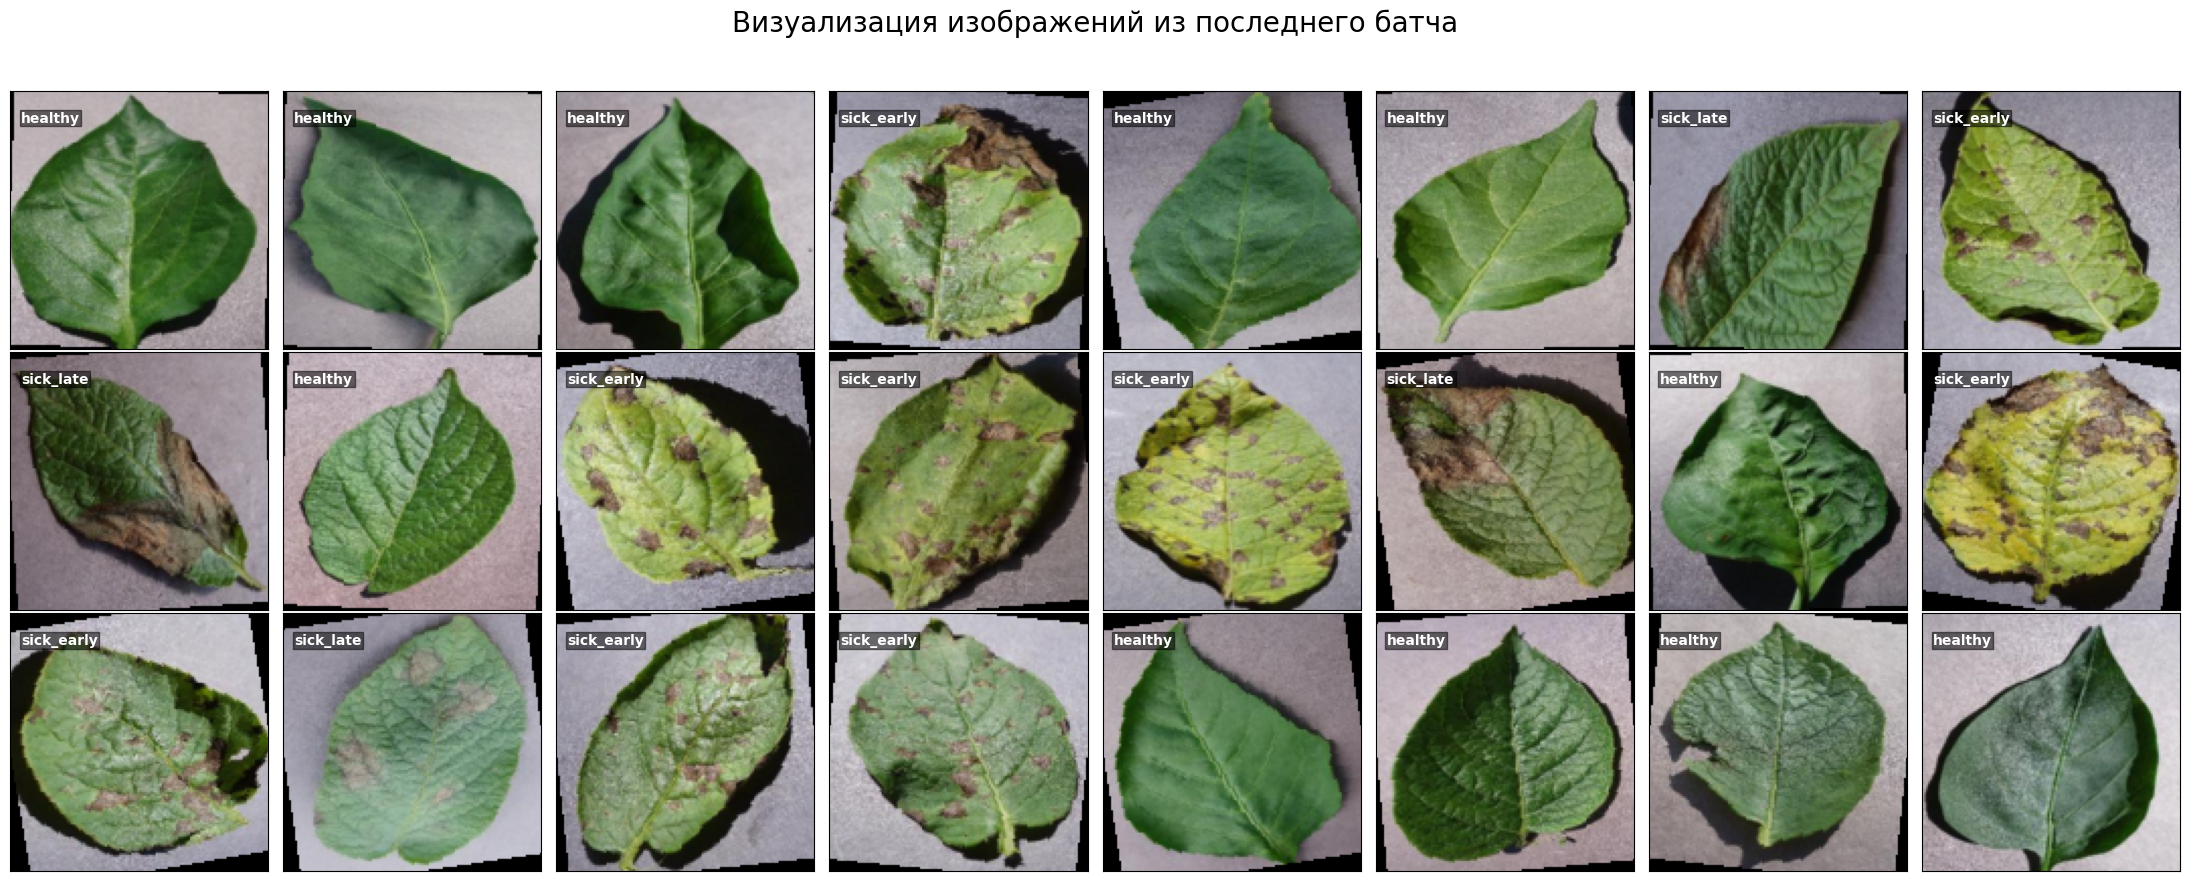

In [59]:
# Основной блок выполнения вынесла сюда

PATH_TO_TRAIN_DATA = "/content/drive/MyDrive/my_colab_data/Plants/Train/"
PROCESSED_DATA_DIR = './processed_data'
CSV_PATH = './plant_dataset.csv'
CLASSES = {0: 'sick_late', 1: 'sick_early', 2: 'healthy'}

if not os.path.exists(CSV_PATH):
    prepare_dataset(path_dataset=PATH_TO_TRAIN_DATA, output_dir=PROCESSED_DATA_DIR, csv_path=CSV_PATH)
else:
    print(f"Файл {CSV_PATH} уже существует, подготовка данных пропущена.")

# Объединяем все трансформации в один пайплайн
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(csv_file=CSV_PATH, transform=transform)
print(f"Датасет создан, количество изображений: {len(dataset)}")

# Оценка производительности
performance_results, last_batch = evaluate_pipeline_performance(dataset, num_classes=len(CLASSES))

# Результат
results_df = pd.DataFrame(performance_results)
print("\nИтоговая таблица производительности")
print(results_df.to_markdown(index=False, tablefmt="grid"))

# Визуализируем последний батч
if last_batch:
    images, labels = last_batch
    visualize_batch(images, labels, CLASSES)